<a href="https://colab.research.google.com/github/econdatatech/AIML429/blob/main/EMBernoulli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


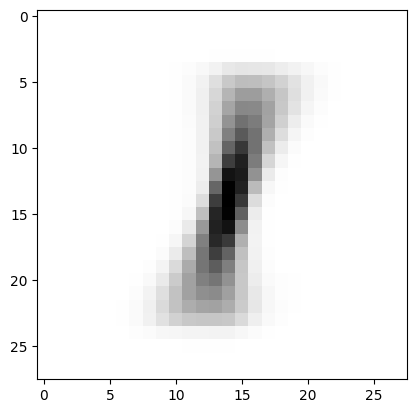

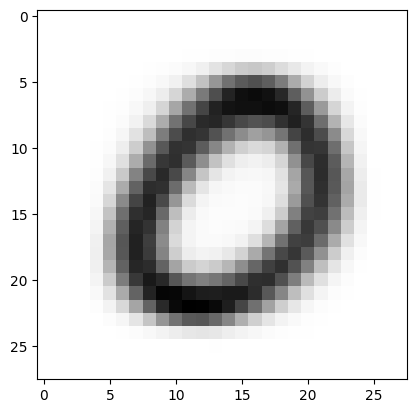

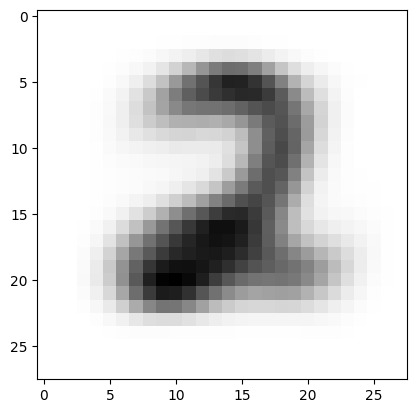

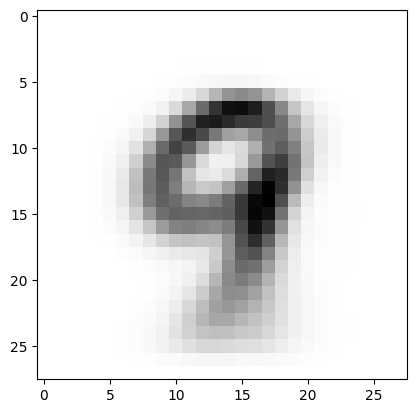

[None, None, None, None]

In [1]:
!pip install -q scikit-datasets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
#Convert it to a binary scale using a threshold of 128.
mnist_data = pd.DataFrame((mnist.data/128).astype('int'))
mnist_label =  mnist['target'].cat.codes

def show(image):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=plt.cm.Greys)
    imgplot.set_interpolation('nearest')
    plt.show()

def bernoulliMStep(data, resp):
    N = len(data)
    D = len(data[0])
    K = len(resp[0])

    Nk = np.sum(resp, axis=0)
    mus = np.empty((K,D))

    for k in range(K): #calculate over K cluster/mixtures
            mus[k] = np.sum(resp[:,k][:,np.newaxis]*data,axis=0)/Nk[k] #sum is over N data points
    return (Nk/N, mus)

def bernoulliEStep(data, mixtureweights, means):
    N = len(data)
    K = len(means)

    prob = np.zeros((N, K))

    for i in range(N): #sum over all data points
        for k in range(K): #calculate over all mixtures
            prob[i,k] = np.prod((means[k]**data[i])*((1-means[k])**(1-data[i])))
    # calculate the numerator of the resp.s
    prob = prob*mixtureweights

    # calcualte the denominator of the resp.s
    row_sums = prob.sum(axis=1)[:, np.newaxis]

    # calculate the resp.s
    resp = prob/row_sums

    return resp

def llBernoulli(data, mixtureweights, means, resp):
    N = len(data)
    K = len(means)

    ll = 0
    for i in range(N): #sum over all data points
        sumK = 0
        for k in range(K): #calculate over all mixtures
            try:
                temp1 = ((means[k]**data[i])*((1-means[k])**(1-data[i])))
                temp1 = np.log(temp1.clip(min=1e-50))

            except:
                print("Problem computing log(probability)")
            sumK += resp[i, k]*(np.log(mixtureweights[k])+np.sum(temp1))
        ll += sumK

    return ll

def mixOfBernoulliEM(data, init_weights, init_means, maxiters=1000, relgap=1e-4, verbose=False):
    '''EM algo fo Mixture of Bernoulli Distributions'''
    N = len(data)
    D = len(data[0])
    K = len(init_means)

    #initalize
    weights = init_weights[:]
    means = init_means[:]
    resp = bernoulliEStep(data, weights, means)
    ll = llBernoulli(data, weights, means,resp)
    ll_old = ll

    for i in range(maxiters):
        if verbose and (i % 5 ==0):
            print("iteration {}:".format(i))
            print("   {}:".format(weights))
            print("   {:.6}".format(ll))

        #E Step: calculate resps
        #For 0th step, done as part of initialization

        #M Step
        weights, means = bernoulliMStep(data, resp)

        #convergence check
        resp = bernoulliEStep(data, weights, means)
        ll = llBernoulli(data, weights, means,resp)
        if np.abs(ll-ll_old)<relgap:
            print("Relative gap:{:.8} at iternations {}".format(ll-ll_old, i))
            break
        else:
            ll_old = ll

    return (weights, means,ll)

def experiments(digits, K, iters=50):
    expData = np.array([mnist_data .iloc[i] for i in range(len(mnist_data )) if mnist_label[i] in digits])

    D = len(expData[0])

    initWts = np.random.uniform(.25,.75,K)
    tot = np.sum(initWts)
    initWts = initWts/tot

    initMeans = np.full((K, D), 1.0/K)

    return mixOfBernoulliEM(expData, initWts, initMeans, maxiters=iters, relgap=1e-15)

number_of_EM_iterations  = 50
digits_to_include = [0,1,2,9]
number_of_mixtures=len(digits_to_include)
finWeights, finMeans, finll = experiments(digits_to_include,number_of_mixtures , number_of_EM_iterations)
[show(finMeans[i].reshape(28,28)) for i in range(len(finMeans))]

In [ ]:
number_of_EM_iterations  = 50
digits_to_include = [0,1,2,9]
results = []
for i in range(1,10):
    finWeights, finMeans, finll = experiments(digits_to_include,i , number_of_EM_iterations)
    results.append(finll)
results

plt.plot(results)

<ipython-input-1-6e0cf7e87b8c>:48: RuntimeWarning: invalid value encountered in true_divide
  resp = prob/row_sums
